In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  5


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

5 Physical GPUs, 1 Logical GPU


In [4]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

In [5]:
def sample_maximizers_simple(model, num_maximizers, num_samples, input_dims, low, high):
    maximizers = np.zeros((num_maximizers, input_dims))
    for i in range(num_maximizers):
        xx = np.random.uniform(low, high, (num_samples, input_dims))
        samples = np.squeeze(model.predict_f_samples(xx, 1))  # (num_maximizers)
        samples_argmax = np.argmax(samples)
        maximizers[i] = xx[samples_argmax]
    return maximizers

## 1-D:

In [6]:
x_data = uniform_grid(1, 10, low=0.01, high=0.99)
y_data = np.expand_dims(-PBO.objectives.forrester(x_data), axis=1)

m = gpflow.models.SVGP(
                     kernel=gpflow.kernels.RBF(lengthscale=0.1),
                     likelihood=gpflow.likelihoods.Gaussian(),
                     inducing_variable=uniform_grid(1, 10, low=0.01, high=0.99))
m.kernel.lengthscale.trainable = False

In [7]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(lambda: -m.log_likelihood((x_data, y_data)), m.trainable_variables)

      fun: 30.149634003463316
 hess_inv: <77x77 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.81887889e-03,  1.20638320e-03,  1.12754959e-03, -8.26037357e-04,
       -5.92810950e-03, -3.34360743e-03, -1.00084953e-02,  4.37334039e-04,
        2.72026218e-69, -7.67206035e-03, -7.98178596e-05,  5.60897770e-04,
        2.25399692e-04,  8.38976585e-04,  1.39405481e-04,  1.68951526e-04,
        1.02263105e-03, -5.21816401e-04, -1.68285306e-04,  4.62744649e-04,
       -8.37669141e-04, -3.07893287e-05, -7.13894099e-04, -4.61804950e-05,
        5.57793967e-05, -4.60641213e-04, -1.42144893e-04,  2.98073021e-04,
       -4.16028200e-05, -2.04788860e-05,  3.19297987e-05,  2.58428895e-04,
       -4.92608708e-04,  5.20923113e-04, -3.13139083e-05, -1.61219837e-06,
        3.52091264e-07,  6.03081015e-08, -7.58391762e-11, -6.47853810e-10,
        5.23224049e-10, -3.53605204e-09, -3.22558719e-04,  2.22644099e-04,
       -1.28822240e-04,  2.20561534e-05, -3.52748001e-05,  4.09903367e-05,
 

In [8]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,27.94034874602659
SVGP.kernel.lengthscale,Parameter,Softplus,,False,(),float64,0.10000000000000007
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,3.2221755200343125
SVGP.inducing_variable.Z,Parameter,,,True,"(10, 1)",float64,[[0.12623383...
SVGP.q_mu,Parameter,,,True,"(10, 1)",float64,[[1.22071686e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[3.01987962e-01, 0.00000000e+00, 0.00000000e+00..."


(-0.0, 1.0)

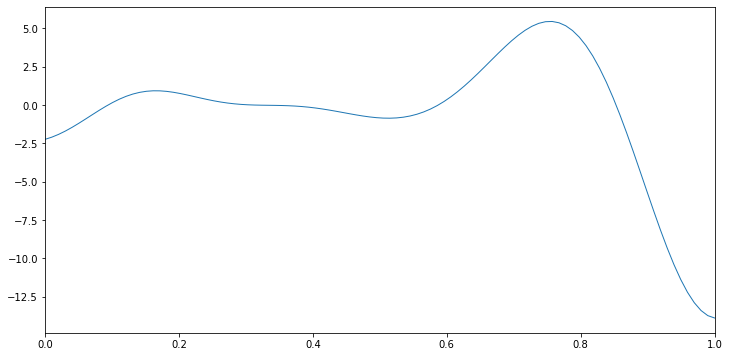

In [9]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, m.predict_f(xx)[0], 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [10]:
sample_maximizers_simple(m, 100, 100, 1, 0., 1.)

array([[0.76059472],
       [0.70817745],
       [0.73540191],
       [0.73245967],
       [0.72090898],
       [0.72734159],
       [0.78896397],
       [0.77485509],
       [0.75821794],
       [0.73294118],
       [0.72613274],
       [0.75954923],
       [0.7882016 ],
       [0.69654779],
       [0.73826418],
       [0.16465377],
       [0.70436018],
       [0.75634786],
       [0.72501295],
       [0.78889087],
       [0.73067131],
       [0.73893388],
       [0.16366165],
       [0.70891976],
       [0.79277298],
       [0.72708585],
       [0.73435455],
       [0.74461664],
       [0.77868969],
       [0.73204459],
       [0.74323527],
       [0.77768953],
       [0.73900635],
       [0.7817737 ],
       [0.7647938 ],
       [0.17214905],
       [0.73906401],
       [0.77396122],
       [0.79825162],
       [0.71286527],
       [0.70982365],
       [0.78626356],
       [0.70001934],
       [0.78365418],
       [0.71711394],
       [0.74601627],
       [0.73935699],
       [0.686

In [11]:
maximizers = PBO.fourier_features.sample_maximizers(X=m.inducing_variable.Z.numpy(),
                                                    count=100,
                                                    n_init=100,
                                                    D=100,
                                                    model=m,
                                                    min_val=0.,
                                                    max_val=1.)

Loss at step 0: 1809.25200563817
Loss at step 500: -6654.381197980947
Loss at step 790: -6671.81202463649


In [12]:
maximizers

<tf.Tensor: shape=(100, 1), dtype=float64, numpy=
array([[0.71582141],
       [0.70262596],
       [0.69047718],
       [0.74250867],
       [0.66566483],
       [0.7312071 ],
       [0.7208569 ],
       [0.68618178],
       [0.7443212 ],
       [0.67923789],
       [0.74697495],
       [0.74096969],
       [0.72884283],
       [0.70459066],
       [0.6210355 ],
       [0.7078772 ],
       [0.75370768],
       [0.74361673],
       [0.75776352],
       [0.73593023],
       [0.68119688],
       [0.74330634],
       [0.74778992],
       [0.76792557],
       [0.74090899],
       [0.70722884],
       [0.74243158],
       [0.60620287],
       [0.7118502 ],
       [0.72634598],
       [0.71723175],
       [0.75658273],
       [0.65017355],
       [0.72238873],
       [0.72028861],
       [0.74393965],
       [0.70329405],
       [0.71756436],
       [0.69428545],
       [0.66541116],
       [0.72631003],
       [0.66011604],
       [0.73250392],
       [0.73389921],
       [0.34063931],
     

We see that in the 1-D case, both methods give reasonable results close to the peak of the function.

# 2-D:

In [13]:
x_data = uniform_grid(2, 10, low=-1.4, high=1.4)
y_data = np.expand_dims(-PBO.objectives.six_hump_camel(x_data), axis=1) + 7

m1 = gpflow.models.SVGP(
                     kernel=gpflow.kernels.RBF(lengthscale=0.3),
                     likelihood=gpflow.likelihoods.Gaussian(),
                     inducing_variable=x_data)

In [14]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(lambda: -m1.log_likelihood((x_data, y_data)), m1.trainable_variables)

      fun: 68.59355476687787
 hess_inv: <5353x5353 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 21.95947312, -17.07140164,   3.55376797, ...,  -0.45986881,
         0.05801014,   1.32485444])
  message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 15001
      nit: 13978
   status: 1
  success: False
        x: array([-0.79605266, -1.30041132, -1.08115232, ...,  0.03658143,
        0.35242949,  0.12520039])

In [15]:
print_summary(m1)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,29.333972924704447
SVGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.7549926764570646
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0036688908192929652
SVGP.inducing_variable.Z,Parameter,,,True,"(100, 2)",float64,"[[-0.79605266, -1.30041132..."
SVGP.q_mu,Parameter,,,True,"(100, 1)",float64,[[-0.12024401...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[8.49670370e-03, 0.00000000e+00, 0.00000000e+00..."


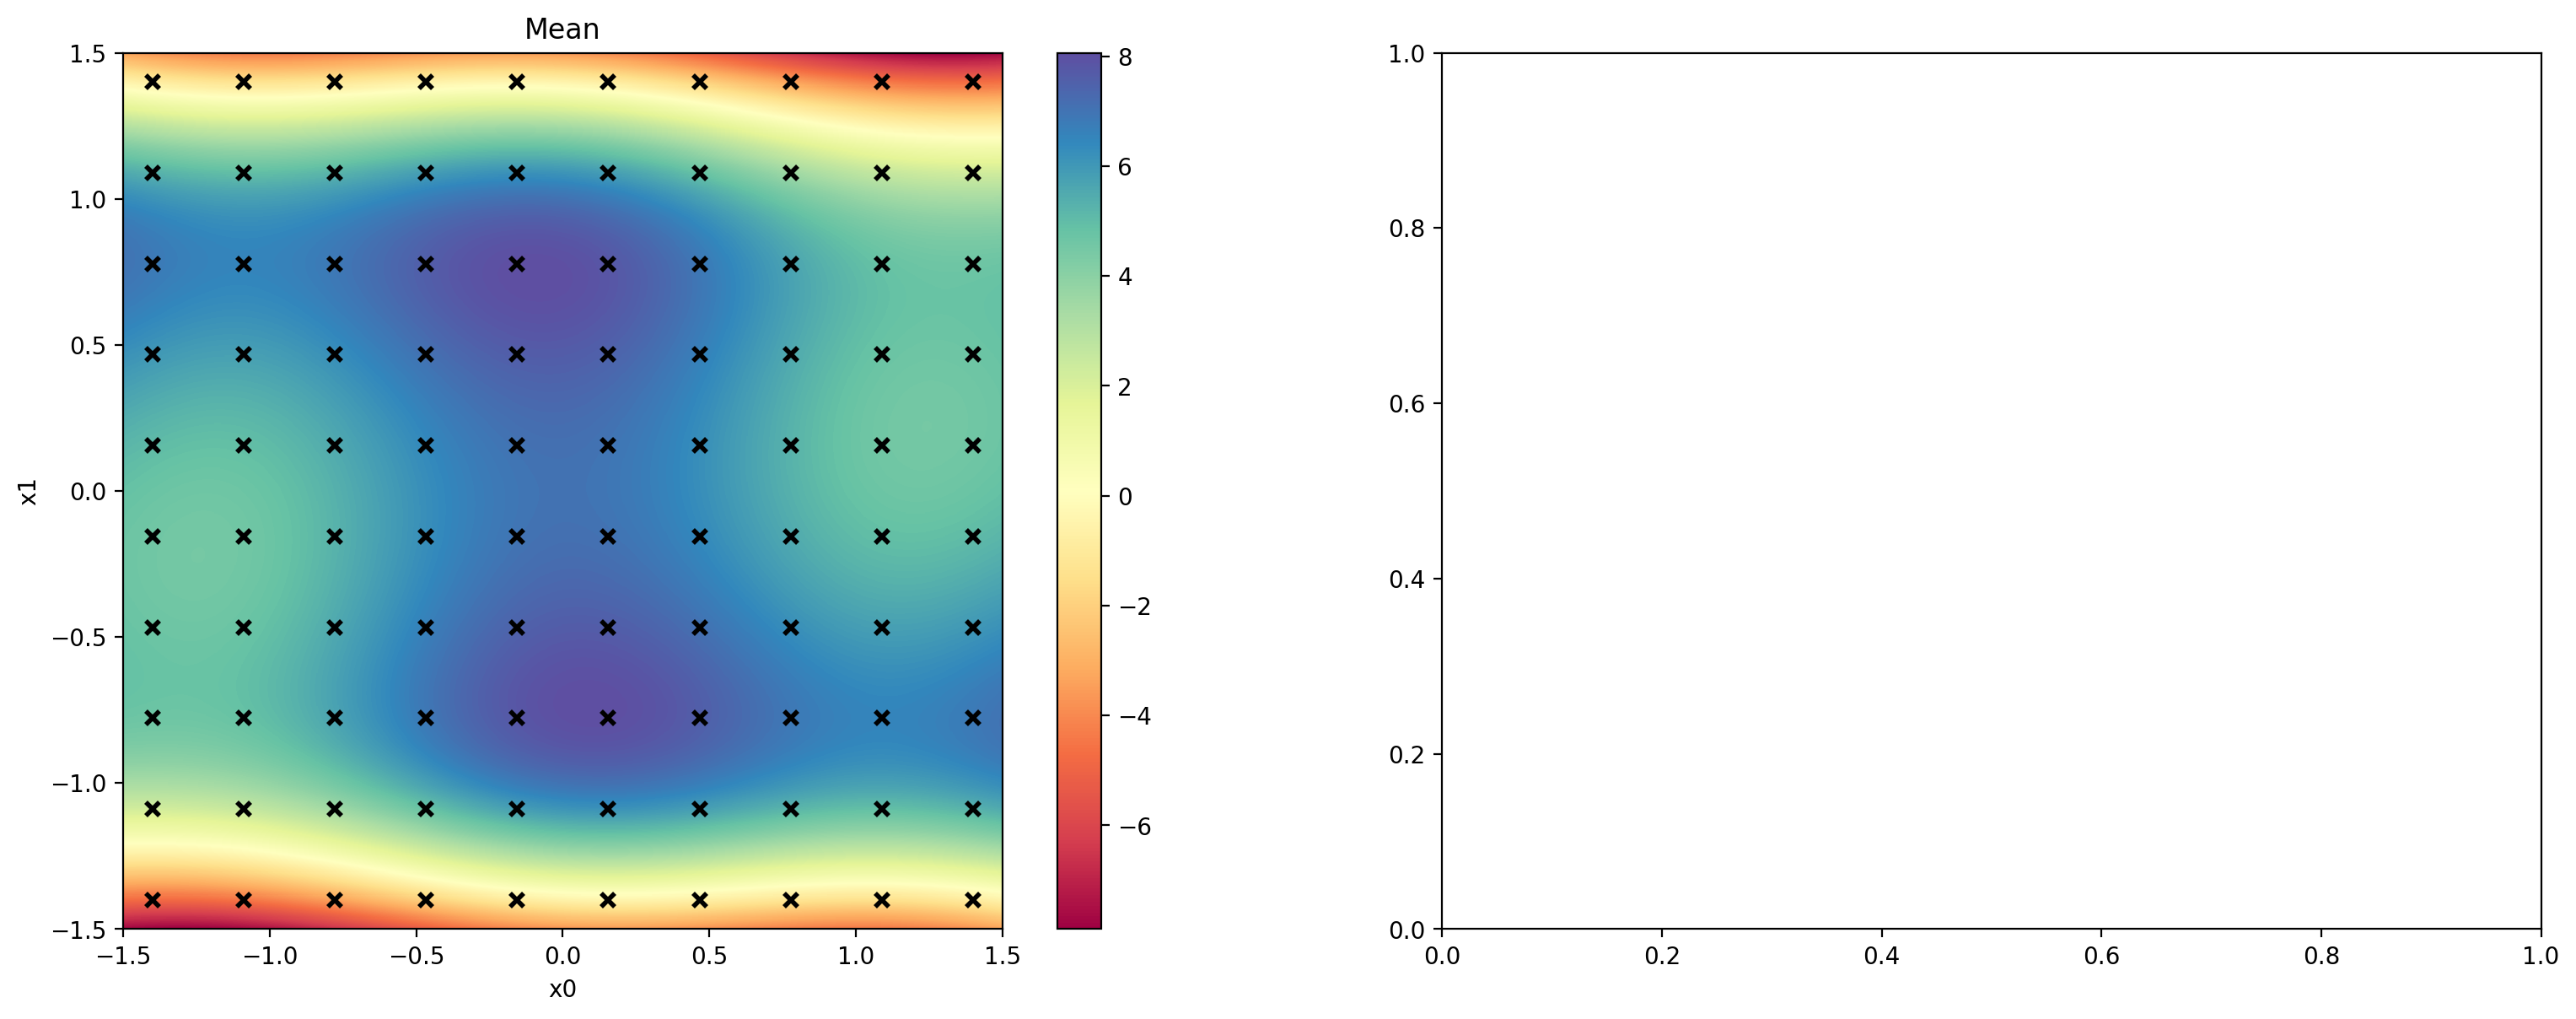

In [16]:
num_discrete_per_dim = 1000
cmap = 'Spectral'
#side = np.linspace(objective_low, objective_high, num_discrete_per_dim)
side = np.linspace(-1.5, 1.5, num_discrete_per_dim)
combs = PBO.acquisitions.dts.combinations(np.expand_dims(side, axis=1))
predictions = m1.predict_y(combs)
preds = tf.transpose(tf.reshape(predictions[0], [num_discrete_per_dim, num_discrete_per_dim]))
variances = tf.transpose(tf.reshape(predictions[1], [num_discrete_per_dim, num_discrete_per_dim]))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6.88)
fig.set_dpi((200))

ax1.axis('equal')
im1 = ax1.imshow(preds, 
                 interpolation='nearest', 
                 #extent=(objective_low, objective_high, objective_low, objective_high), 
                 extent=(-1.5, 1.5, -1.5, 1.5), 
                 origin='lower', 
                 cmap=cmap)
ax1.plot(x_data[:, 0], x_data[:, 1], 'kx', mew=2)

ax1.set_title("Mean")
ax1.set_xlabel("x0")
ax1.set_ylabel("x1")
fig.colorbar(im1, ax=ax1)

In [17]:
maximizers = sample_maximizers_simple(m1, 100, 100, 2, -1.5, 1.5)

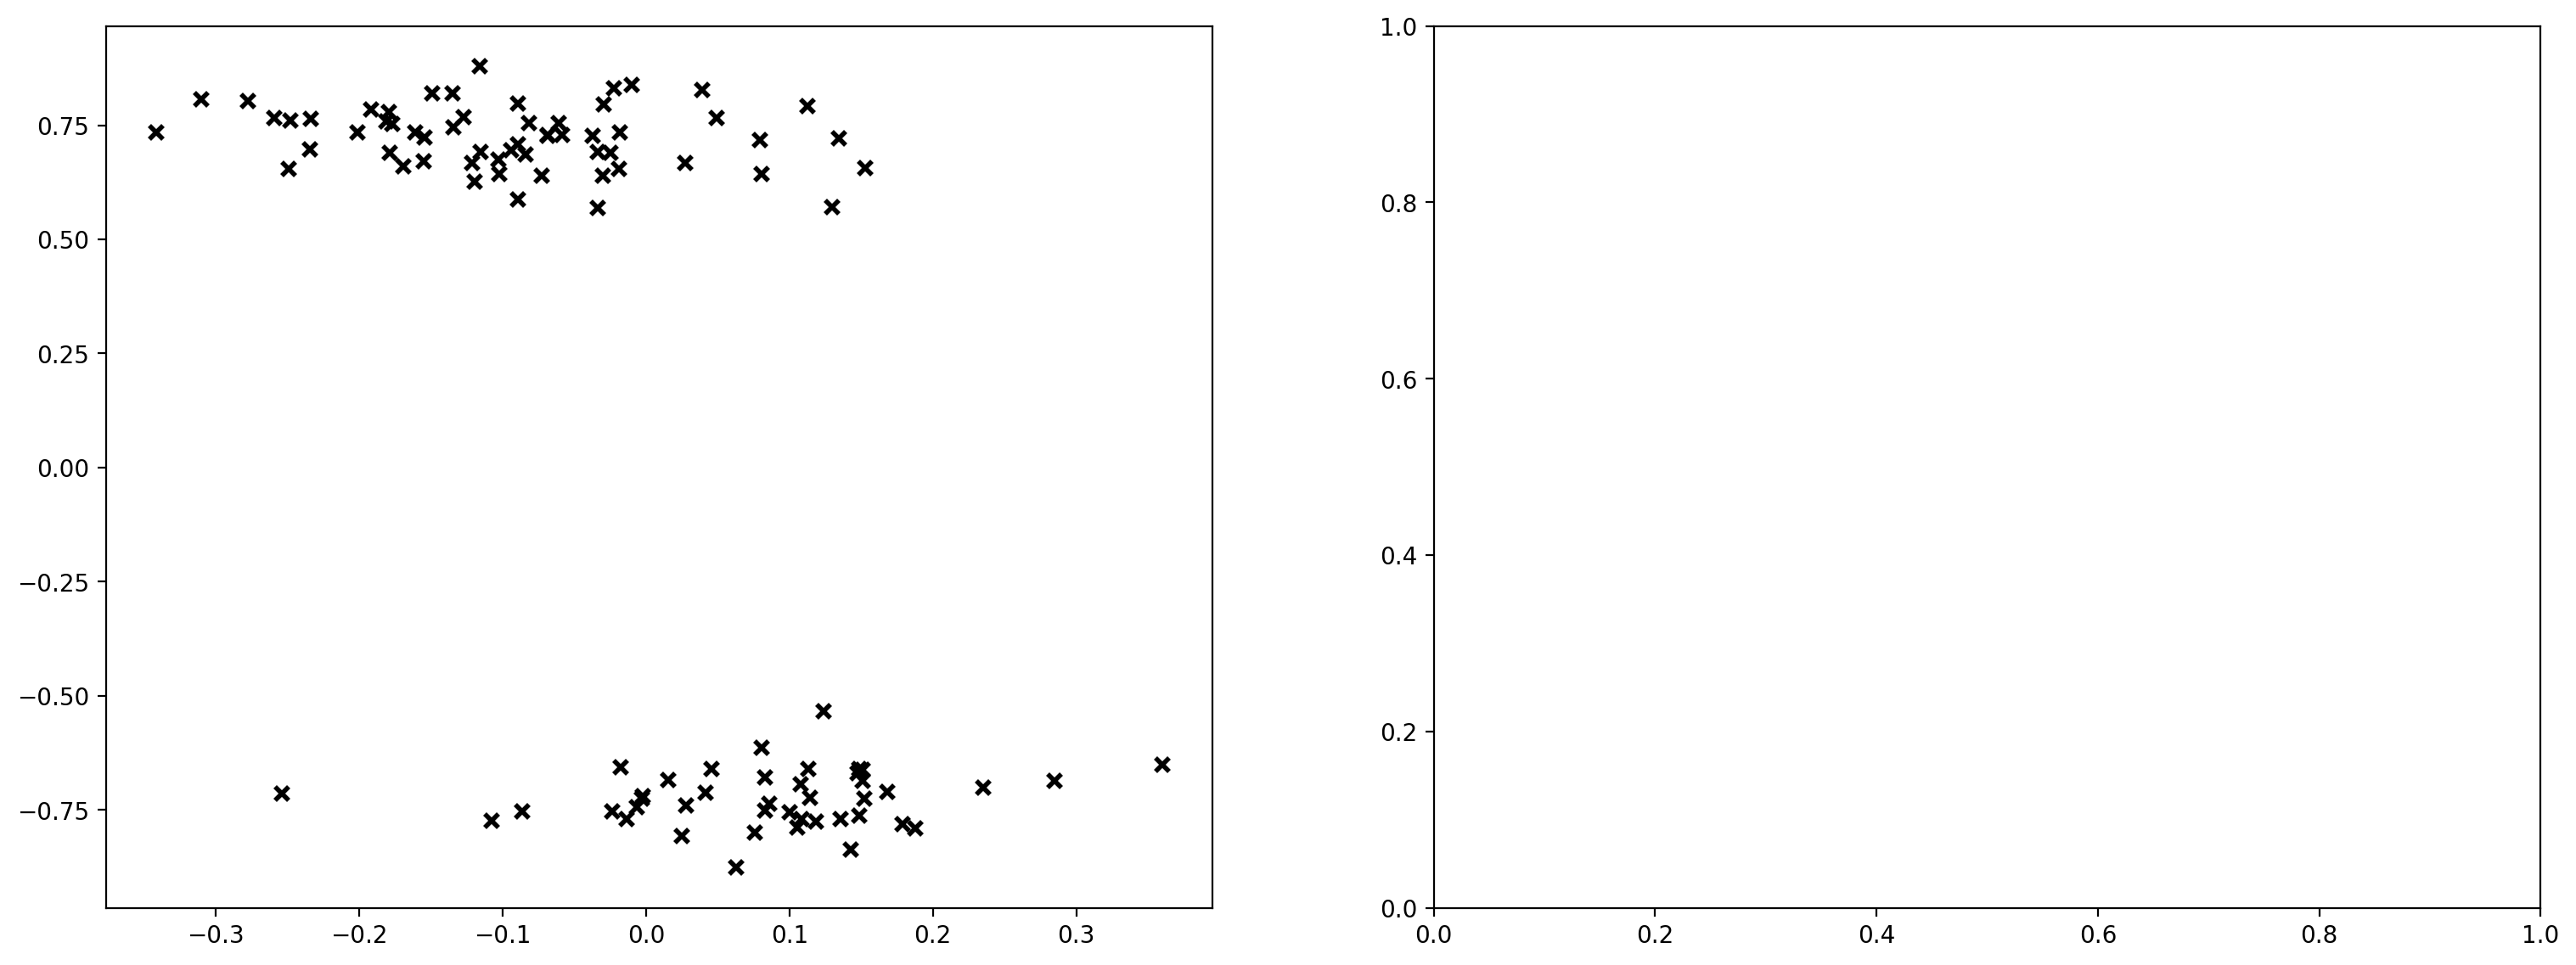

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6.88)
fig.set_dpi((200))
ax1.plot(maximizers[:, 0], maximizers[:, 1], 'kx', mew=2)

We see that the simple method gives values centered around the 2 peaks at x = [0.0898, -0.7126] and x = [-0.0898, 0.7126]

In [19]:
maximizers = PBO.fourier_features.sample_maximizers(X=m1.inducing_variable.Z.numpy(),
                                                    count=50,
                                                    n_init=100,
                                                    D=1000,
                                                    model=m1,
                                                    min_val=-1.5,
                                                    max_val=1.5)

Loss at step 0: 171800470.85459203
Loss at step 500: -447701562.33074373
Loss at step 1000: -796925052.479242
Loss at step 1500: -922783953.4096239
Loss at step 2000: -959127221.6533737
Loss at step 2500: -969320253.4169631


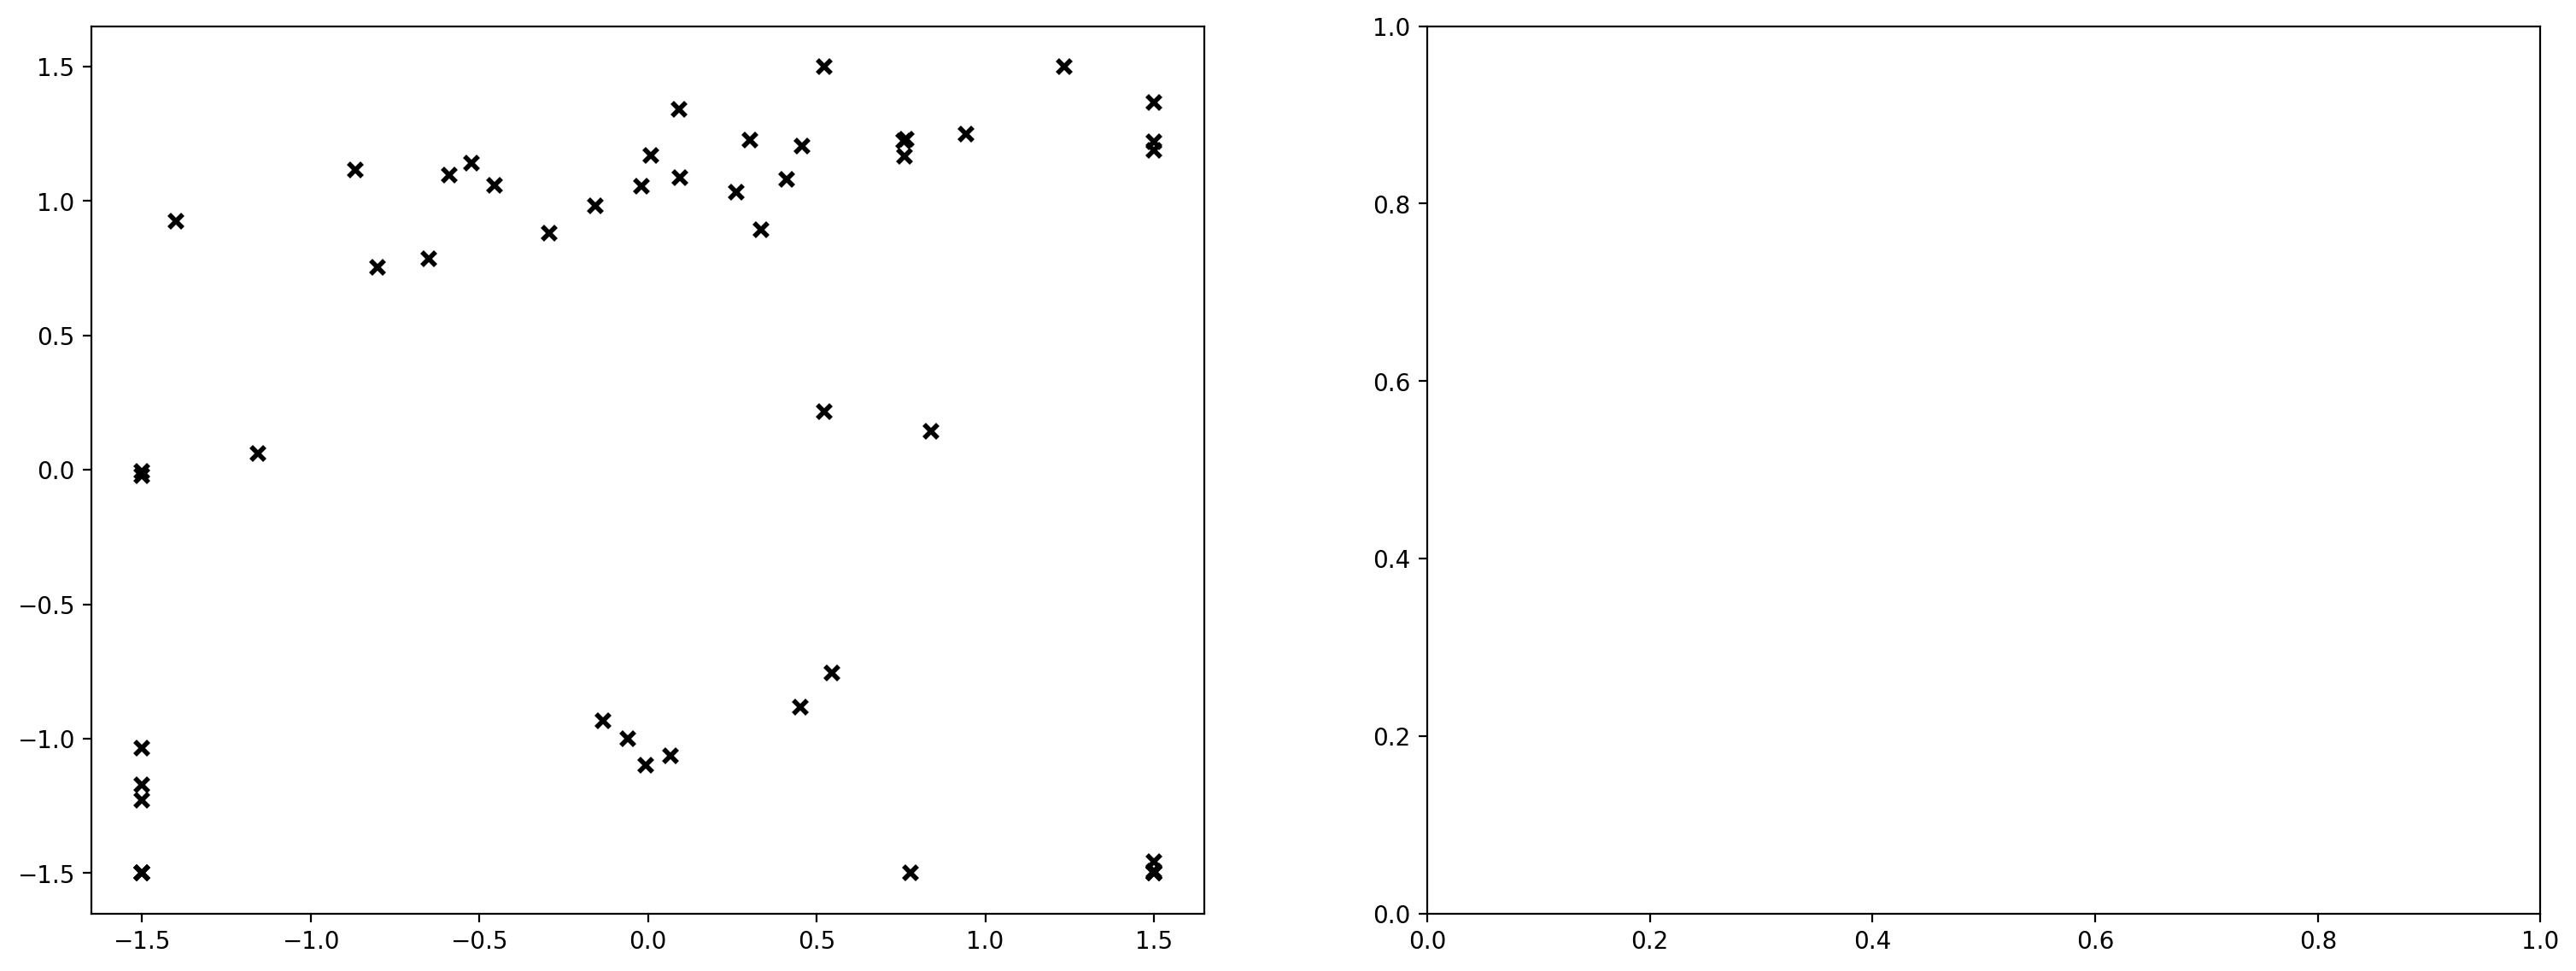

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6.88)
fig.set_dpi((200))
ax1.plot(maximizers[:, 0], maximizers[:, 1], 'kx', mew=2)

Whereas the Fourier features method does not.

We test to see if the Fourier features method roughly approximates the model's kernel:

In [21]:
test = np.array([[0.1, 0.3],
                 [0.3, 0.4],
                [0.5, 1.19]])

In [22]:
m1.kernel.K(test)

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[29.33397292, 28.0752317 , 12.72528957],
       [28.0752317 , 29.33397292, 16.38254958],
       [12.72528957, 16.38254958, 29.33397292]])>

In [23]:
total = np.zeros((1,3,3))
for i in range(100):
    phi, W, b, theta = PBO.fourier_features.sample_features_weights(np.expand_dims(m1.inducing_variable.Z.numpy(), axis=0), m1, 100)
    ff_mat = PBO.fourier_features.fourier_features(np.expand_dims(test, axis=0), W, b)
    total += ff_mat @ tf.linalg.matrix_transpose(ff_mat)
print(total/100 * m1.kernel.variance.numpy()) 

tf.Tensor(
[[[29.17840411 27.87835908 12.6895465 ]
  [27.87835908 29.08359123 16.32238824]
  [12.6895465  16.32238824 29.23823653]]], shape=(1, 3, 3), dtype=float64)


And we see that it does. Hence the bug is probably somewhere after the Fourier features conversion (in the maximizing?)